In [248]:
import torch
import torch.nn as nn
import torch
import numpy as np
from torch.optim.optimizer import Optimizer
import functools
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

device = torch.device('cuda')

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`

    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])


def jacobian(outputs, inputs, create_graph=False,retain_graph=True):
    '''
    Compute the Jacobian of `outputs` with respect to `inputs`

    jacobian(x, x)
    jacobian(x * y, [x, y])
    jacobian([x * y, x.sqrt()], [x, y])
    '''
    if torch.is_tensor(outputs):
        outputs = [outputs]
    else:
        outputs = list(outputs)

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    jac = []
    for output in outputs:
        output_flat = output.view(-1)
        output_grad = torch.zeros_like(output_flat)
        for i in range(len(output_flat)):
            output_grad[i] = 1
            jac += [gradient(output_flat, inputs, output_grad, retain_graph, create_graph)]
            output_grad[i] = 0
    return torch.stack(jac)



In [249]:
inputs = torch.randn(10, requires_grad=True)
net = nn.Linear(10, 3)
outputs = net(inputs)
outputs_flat = outputs.view(-1)
outputs_grad = torch.zeros_like(outputs_flat)
jac = []
for i in range(len(outputs_flat)):
    outputs_grad[i] = 1
    jac += [gradient(outputs_flat, inputs, outputs_grad, retain_graph=True, create_graph=False)]
    outputs_grad[i] = 0

torch.stack(jac).shape

torch.Size([3, 10])

### Customized Levenberg-Marquardt Optimizer

In [250]:
class LM(Optimizer):
    '''
    Arguments:
        lr: learning rate (step size) default:1
        alpha: the hyperparameter in the regularization default:0.2
    '''
    def __init__(self, params, lr=1, alpha=0.2):
        defaults = dict(
            lr = lr,
            alpha = alpha
        )
        super(LM, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError ("LM doesn't support per-parameter options") 

        self._params = self.param_groups[0]['params']
    
    def step(self, closure=None):
        '''
        performs a single step
        in the closure: we evaluate the diff

        '''
        assert len(self.param_groups) == 1
        group = self.param_groups[0]
        lr = group['lr']
        alpha = group['alpha']
        params = group['params']

        # if closure is not None:
        #     with torch.enable_grad():
        diff= closure().float()


        # diff = closure().float()
        # print(diff)
        # calculate Jacobian
        J = jacobian(diff,params , create_graph=True, retain_graph=True).detach()
        prev_loss = torch.mean(diff.detach() ** 2)
        # print (prev_loss.item())
        # approximate Hessian
        H = torch.matmul(J.T, J) + torch.eye(J.shape[-1]).to(device) * alpha
        # calculate the update       
        delta_w = -1 * torch.matmul(torch.inverse(H), torch.matmul(J.T, diff)).detach()
        offset = 0
        for p in group['params']:
            numel = p.numel()
            with torch.no_grad():
                p.add_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
            offset += numel

        diff = closure().float()
        loss = torch.mean(diff.detach() ** 2)
        # print (loss.item())
        if loss < prev_loss:
            print(loss.data)
            # print ('successful iteration')
            if alpha > 1e-5:
                group['alpha'] /= 10
        else:
            # print ('failed iteration')
            if alpha < 1e5:
                group['alpha'] *= 10
            # undo the step
            offset = 0
            for p in group['params']:    
                numel = p.numel()
                with torch.no_grad():
                    p.sub_( delta_w[offset:offset + numel].view_as(p),alpha=lr)
                offset += numel
        
        

In [251]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ELU(),
        torch.nn.Linear(10, 1),
    )
net.cuda('cuda:0')

optimizer = LM(net.parameters(),lr=1)

BATCH_SIZE = 64
EPOCH = 200
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  
y = torch.sin(x) + 0.2*torch.rand(x.size())
data, target = x.to('cuda:0'), y.to('cuda:0')


In [252]:
n_iter=200
def closure():
    out = net(data)
    diff = (out - target).squeeze()
    return diff
for iter in range(n_iter):
    # print ('iter:{}'.format(iter))
    optimizer.zero_grad()
    optimizer.step(closure)


tensor(0.6066, device='cuda:0')
tensor(0.4269, device='cuda:0')
tensor(0.4192, device='cuda:0')
tensor(0.4113, device='cuda:0')
tensor(0.4026, device='cuda:0')
tensor(0.3931, device='cuda:0')
tensor(0.3830, device='cuda:0')
tensor(0.3725, device='cuda:0')
tensor(0.3223, device='cuda:0')
tensor(0.3114, device='cuda:0')
tensor(0.2484, device='cuda:0')
tensor(0.2356, device='cuda:0')
tensor(0.2260, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2165, device='cuda:0')
tensor(0.2132, device='cuda:0')
tensor(0.2105, device='cuda:0')
tensor(0.2081, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(0.2040, device='cuda:0')
tensor(0.2022, device='cuda:0')
tensor(0.2004, device='cuda:0')
tensor(0.1985, device='cuda:0')
tensor(0.1965, device='cuda:0')
tensor(0.1942, device='cuda:0')
tensor(0.1911, device='cuda:0')
tensor(0.1868, device='cuda:0')
tensor(0.1849, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(0.1633, device='cuda:0')
tensor(0.1566, device='cuda:0')
tensor(0

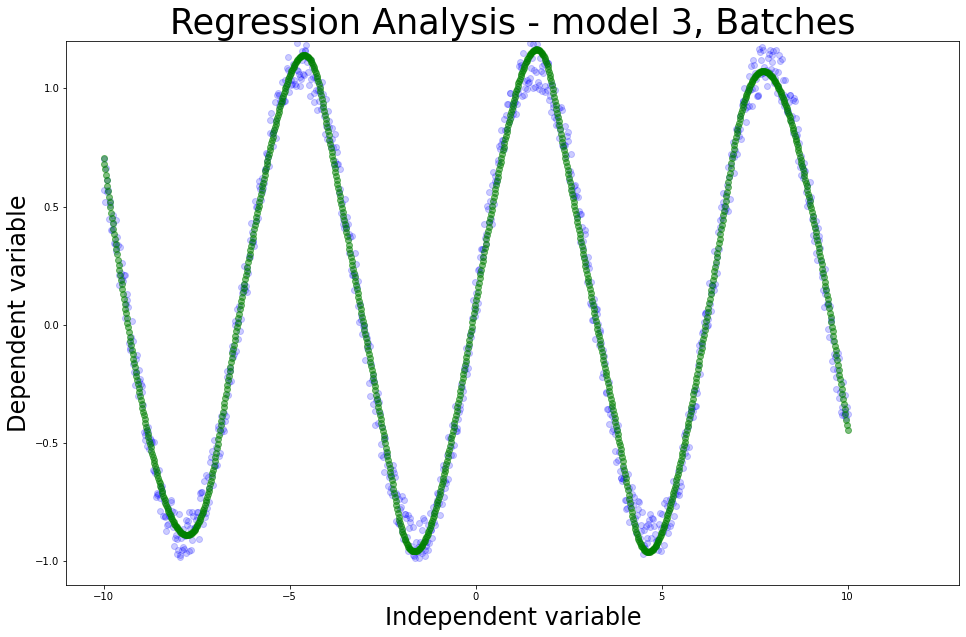

In [253]:
fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Regression Analysis - model 3, Batches', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.set_xlim(-11.0, 13.0)
ax.set_ylim(-1.1, 1.2)
ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue", alpha=0.2)
prediction = net(x.cuda('cuda:0'))     # input x and predict based on x
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color='green', alpha=0.5)
plt.show()

In [1]:
def getClosestFactor(target, number):
    for  i in range(number):
        if (number % (target + i) == 0):
            return target + i
        elif (number % (target - i) == 0):
            return target - i
    return number

In [3]:
getClosestFactor(10,20061)

9

In [4]:
20061/9

2229.0

In [7]:
import torch
from torch.autograd import Variable

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
x, y = Variable(x), Variable(y)

In [8]:
x.shape

torch.Size([1000, 1])

In [9]:
tnestedtensor([
 tensor([8, 1, 3, 4]),
 tensor([5, 0, 9])
]) 

NameError: name 'tnestedtensor' is not defined